<a href="https://colab.research.google.com/github/mbewustanley/Feature_Eng_House_Prices/blob/main/Feature_Eng_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:

"""import os
import warnings"""
#from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


"""# Mute warnings
warnings.filterwarnings('ignore')"""


"# Mute warnings\nwarnings.filterwarnings('ignore')"

In [25]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00


Data Preprocessing:
- Load data from CSV
- Clean to fix errors and inconsistencies
- Encode the statistical data type (numerical, categorical)
- Impute any missing values

TO LOAD

In [3]:
def load_data():
    # Read data
    df_train = pd.read_csv("/content/drive/MyDrive/Kaggle_Datasets/Feature_Eng_House_prices/train.csv", index_col="Id")
    df_test = pd.read_csv("/content/drive/MyDrive/Kaggle_Datasets/Feature_Eng_House_prices/test.csv", index_col="Id")

    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])

    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)

    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


TO CLEAN

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle_Datasets/Feature_Eng_House_prices/train.csv', index_col='Id')
df.Exterior2nd.unique()


array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [5]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df


TO ENCODE

In [6]:

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2",
                "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating",
                "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


Handling Missing values:
- we'll impute 0 for missing numeric values and 'None' for missing categorical variables

In [7]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df


In [8]:
df_train, df_test = load_data()

In [9]:
display(df_train)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,175000.0
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000.0
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500.0


Establishing a Baseline
- i.e. a baseline score to judge our feature engineering against.
- a function to compute the cross-validated RMSLE score for a feature set

In [10]:

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


In [11]:
"""the above scoring function can be used whenever we want to try out a new feature set

Running it on the processed data with no additional features to get our Baseline score"""

X = df_train.copy()
y = X.pop('SalePrice')

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")


#comparing against the baseline helps inform on any possible inprovements from added features

Baseline score: 0.14387 RMSLE


Feature Utility Scores
- using mutual information to compute a utility score for each feature thereby providing us with an indication of how much potential the feature has.
- define 2 utility functions:
-make_mi_scores and plot_mi_scores

In [12]:
def make_mi_scores(X, y):
  X = X.copy()
  for colname in X.select_dtypes(['object', 'category']):
    X[colname], _=X[colname].factorize()
  #All discrete features should now have integer dtypes
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
  mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features, random_state=0)
  mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

def plot_mi(scores):
  scores = scores.sort_values(ascending=True)
  width = np.arrange(len(scores))
  ticks = list(scores.index)
  plt.barh(width, scores)
  plt.yticks(width, scores)
  plt.title('Mutual Information Scores')

In [13]:
#lets look at the feature scores again

X = df_train.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)
mi_scores

,MI Scores
OverallQual,0.571457
Neighborhood,0.526220
GrLivArea,0.430395
YearBuilt,0.407974
LotArea,0.394468
...,...
PoolQC,0.000000
MiscVal,0.000000
MiscFeature,0.000000
YrSold,0.000000


In [14]:
#this shows us that there are a number of features that are highly informative and some that dont seem to be informative at all (at least by themselves)
#Top scoring features will usually pay-off the most during feature development so it's a good idea to focus on those
#training uninformative features can lead to overfitting


In [15]:
#function to drop features with 0.0 scores

def drop_uninformative(df, mi_scores):
  return df.loc[:, mi_scores > 0.0]

#to be used later

CREATE FEATURES


In [16]:
"""make the workflow more modular by defining a function that takes a prepared dataframe
 and passes it through a pipeline of transformations to get the final feature set"""

#first we define a transformation for label encoding for the categorical features
#works for any kind of categorical feature when using a tree-ensemble like XGBoost
#even for unordered categories
#for linear regression models, use a one-hot encoding instead, esp for unordered categories
def label_encode(df):
  X=df.copy()
  for colname in X.select_dtypes(['category']):
    X[colname] = X[colname].cat.codes
  return X



#still on creating features

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X


#other possible transforms:
"""
Interactions between the quality Qual and condition Cond features.
OverallQual, for instance, was a high-scoring feature.
You could try combining it with OverallCond by converting both to integer type and taking a product.

Square roots of area features. This would convert units of square feet to just feet.

Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.

Interactions between numeric and categorical features that describe the same thing.
You could look at interactions between BsmtQual and TotalBsmtSF, for instance.

Other group statistics in Neighboorhood. We did the median of GrLivArea.
Looking at mean, std, or count could be interesting.
You could also try combining the group statistics with other features.
Maybe the difference of GrLivArea and the median is important?"""


'\nInteractions between the quality Qual and condition Cond features.\nOverallQual, for instance, was a high-scoring feature.\nYou could try combining it with OverallCond by converting both to integer type and taking a product.\n\nSquare roots of area features. This would convert units of square feet to just feet.\n\nLogarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.\n\nInteractions between numeric and categorical features that describe the same thing.\nYou could look at interactions between BsmtQual and TotalBsmtSF, for instance.\n\nOther group statistics in Neighboorhood. We did the median of GrLivArea.\nLooking at mean, std, or count could be interesting.\nYou could also try combining the group statistics with other features.\nMaybe the difference of GrLivArea and the median is important?'

**Using Unsupervised models to create features**

K-Means Clustering


*we could use the clusters labels as features or the distance between observations to each cluster.*


In [17]:
cluster_features = ["LotArea", "TotalBsmtSF", "FirstFlrSF", "sECONDfLRsf", "GrLivArea"]

def cluster_labels(df, features, n_clusters=20):
  X = df.copy()
  X_Scaled = X.loc[:,features]
  X_Scaled = (X_Scaled - X_Scaled.mean(axis=0)) / X_Scaled.std(axis=0)
  kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
  X_new = pd.DataFrame()
  X_new['cluster'] = kmeans.fit_transform(X_Scaled)
  return X_new

def cluster_distance(df, features, n_clusters=20):
  X = df.copy()
  X_scaled = X.loc[:, features]
  X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
  kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
  X_cd = kmeans.fit_transform(X_scaled)
  # Label features and join to dataset
  X_cd = pd.DataFrame(
      X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
  )
  return X_cd

Principal Component Analysis

*PCA could decompose variational structure in data and provide us with loadings that describe each component of variation as well as the components that were the transformed datapoints. These can suggest features to create and the components we cau use as features directly*

In [18]:
#the utility functions


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


In [19]:
#the transforms that produce the features (change these if answers are different)


def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

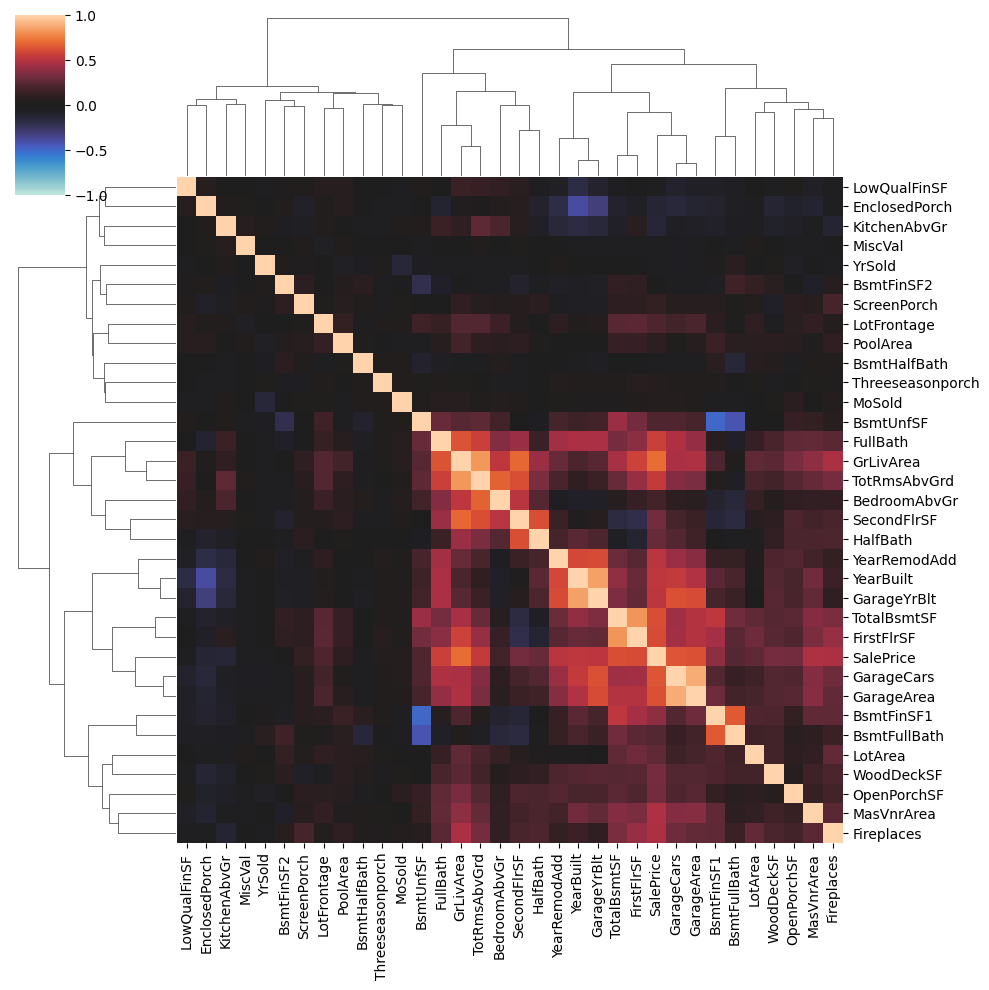

In [20]:
#might want to look at a correlation matrix for further analysis

def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )

#for example
corrplot(df_train, annot=None)

#groups of highly correlated features often yield interesting loadings

Applying PCA for indicating outliers

In [21]:
#houses that have values not well represented in the rest of the data.


#a group of houses in the 'Edwards' neighborhood have a SaleCondition of 'partial'

def indicate_outliers(df):
  X_new = pd.DataFrame()
  X_new['Outlier'] = (df.Neighborhood == "Edwards") and (df.SaleCondition == "Partial")
  return X_new


#we can also consider applying some sort of robust scaler from
#scikit-learn (sklearn.preprocessing) module to the outlying values esp GrLivArea

Target Encoding

In [22]:
#steps:
#we'll split the data into folds each having 2 splits,
#train the encoder on one split but transform the values of the other
#and repeat for all the splits
  #this way, training and transformation always takes place on independent sets of data


class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

Create Final Feature Set

In [33]:
"""combining everything together and putting the transformations into
separate functions to make it easier to experiment with various combinations"""

from category_encoders import MEstimateEncoder


def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

/tmp/ipython-input-1423397393.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")


np.float64(0.13694237566469133)

In [28]:
#Hyperparameter Tunning with XGBoost

X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

/tmp/ipython-input-1423397393.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")


np.float64(0.12491217413174481)

Train Model

In [29]:
"""create my feature set from original data, train XGBoost on training data
and use trained model to make predictions from test set"""


X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))


/tmp/ipython-input-1423397393.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
